In [6]:
!pip install jcopdl

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Dataset & Dataloader**

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [13]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("../input/covid-detection-with-xray-using-deep-learning/COVID-19_Radiography_Dataset/Dataset/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("../input/covid-detection-with-xray-using-deep-learning/COVID-19_Radiography_Dataset/Dataset/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [14]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 64, 64])

In [15]:
label2cat = train_set.classes
label2cat

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

**Arsitektur & Config**

In [16]:
from jcopdl.layers import conv_block, linear_block

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(1, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 4, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [18]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

**Persiapan Training Data**

In [19]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=3, outdir="output_dir")

**Training Data**

In [20]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0435 | Test_cost  = 0.8285 | Train_score = 0.5560 | Test_score = 0.6685 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7927 | Test_cost  = 0.7205 | Train_score = 0.6729 | Test_score = 0.7072 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6982 | Test_cost  = 0.5989 | Train_score = 0.7180 | Test_score = 0.7636 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6359 | Test_cost  = 0.5568 | Train_score = 0.7522 | Test_score = 0.7863 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5905 | Test_cost  = 0.5342 | Train_score = 0.7700 | Test_score = 0.7910 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5677 | Test_cost  = 0.5064 | Train_score = 0.7800 | Test_score = 0.8031 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5346 | Test_cost  = 0.4741 | Train_score = 0.7921 | Test_score = 0.8191 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5248b16320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5248b16320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.5081 | Test_cost  = 0.4742 | Train_score = 0.8058 | Test_score = 0.8246 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4873 | Test_cost  = 0.4634 | Train_score = 0.8126 | Test_score = 0.8264 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4729 | Test_cost  = 0.4121 | Train_score = 0.8178 | Test_score = 0.8427 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4637 | Test_cost  = 0.4049 | Train_score = 0.8227 | Test_score = 0.8449 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4490 | Test_cost  = 0.4106 | Train_score = 0.8299 | Test_score = 0.8437 |
==> EarlyStop patience =  1 | Best test_score: 0.8449


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4274 | Test_cost  = 0.3933 | Train_score = 0.8373 | Test_score = 0.8510 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4277 | Test_cost  = 0.3790 | Train_score = 0.8383 | Test_score = 0.8569 |


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4258 | Test_cost  = 0.3873 | Train_score = 0.8369 | Test_score = 0.8541 |
==> EarlyStop patience =  1 | Best test_score: 0.8569


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4116 | Test_cost  = 0.3827 | Train_score = 0.8430 | Test_score = 0.8524 |
==> EarlyStop patience =  2 | Best test_score: 0.8569


Train:   0%|          | 0/133 [00:00<?, ?it/s]

Test:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4016 | Test_cost  = 0.3742 | Train_score = 0.8480 | Test_score = 0.8522 |
==> EarlyStop patience =  3 | Best test_score: 0.8569
==> Execute Early Stopping at epoch: 17 | Best test_score: 0.8569
==> Best model is saved at output_dir


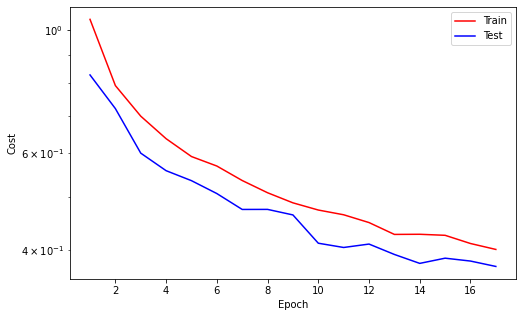

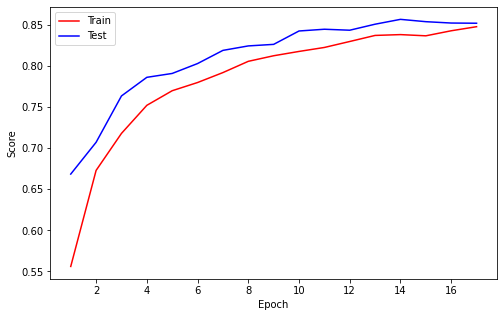

In [21]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

**Prediksi**

In [22]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 0, 2, 0, 1, 2, 2,
        2, 0, 2, 3, 3, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 0, 3, 2, 0, 1, 1, 3, 2, 0, 3, 1, 1, 2, 2, 2, 1, 1, 0, 1,
        2, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 3, 2,
        0, 1, 0, 1, 0, 2, 2, 2, 2, 3, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2,
        3, 0, 2, 3, 2, 3, 3, 1], device='cuda:0')

In [24]:
feature.shape, target.shape

(torch.Size([128, 1, 64, 64]), torch.Size([128]))

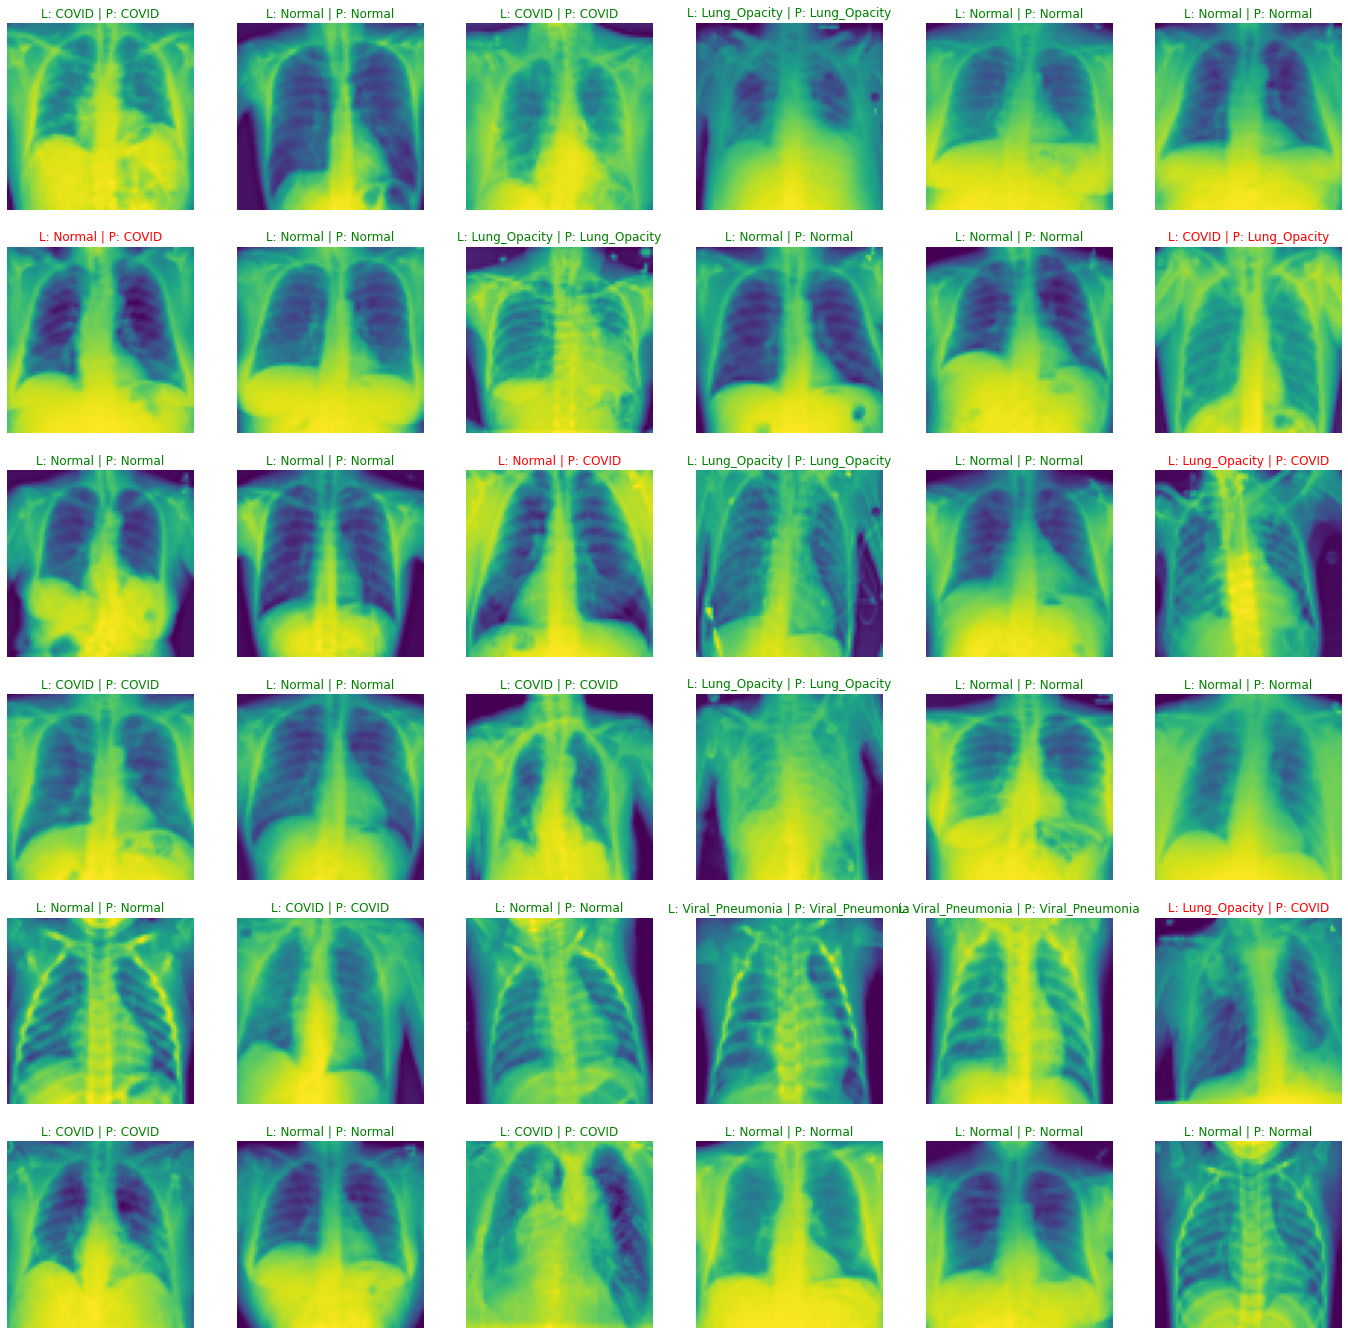

In [25]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');